<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/2_4_2_hipotesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4.2. Hipótesis 2: Reversión a la Media (Mean Reversion)

## 0. Clonamos el repositorio

LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

In [1]:
#Clonamos el repo
!git clone https://github.com/GUNAPILLCO/neural_profit.git

Cloning into 'neural_profit'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 101 (delta 4), reused 5 (delta 2), pack-reused 89 (from 1)
Receiving objects: 100% (101/101), 107.50 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (35/35), done.


## 1. Importación de Librerías

In [5]:
import sys
#!{sys.executable} -m pip install -q pandas_market_calendars
#print("Librería instalada: pandas_market_calendars")

In [6]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

## 2. Carga del dataset mnq_intraday_data

In [7]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    return df

In [8]:
mnq_intraday = load_df()

## 3. Hipótesis 2: Reversión a la Media (Mean Reversion)

**"Si el precio se aleja demasiado de su media móvil de corto plazo, tenderá a volver a ella."**
<br><br>
**Justificación técnica:**<br>
Alta frecuencia tiende a mostrar sobre-reacciones temporales. Este es un principio clásico del análisis técnico. En escalas de tiempo cortas, los precios tienden a oscilar alrededor de su media. Alejamientos extremos suelen generar correcciones rápidas, especialmente en activos líquidos como el MNQ.
<br><br>
**Alpha Factor sugerido:**

$$
\text{mean_reversion_factor}(t) = \frac{close(t) - \text{SMA}_N(t)}{\sigma_N(t)}
$$

Donde:
- $ \text{SMA}_N(t) $ es la media móvil simple de los últimos N minutos.
- ${\sigma_N(t)}$ es la desviación estándar en la misma ventana.

<br><br>
**El z-score te dice cuán lejos está un valor respecto a su promedio, medido en unidades de desviación estándar.**
Es una forma de medir si algo está “muy arriba” o “muy abajo” de lo normal.

## 4. Construcción de alpha factor

Usamos el z-score del precio respecto a su media móvil intradía. Cuanto más extremo el z-score, más probable la reversión.

In [14]:
# 1. Construir alpha factor (z-score del precio respecto a su media móvil y desviación estándar)
for N in [5, 15, 30]:
    sma_col = f'sma_{N}'
    std_col = f'std_{N}'
    z_col = f'zscore_{N}'

    # Media móvil y desviación estándar por jornada
    mnq_intraday[sma_col] = mnq_intraday.groupby('date')['close'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )
    mnq_intraday[std_col] = mnq_intraday.groupby('date')['close'].transform(
        lambda x: x.rolling(window=N, min_periods=1).std()
    )

    # Z-score intradía del precio
    mnq_intraday[z_col] = (mnq_intraday['close'] - mnq_intraday[sma_col]) / mnq_intraday[std_col]

# 2. Normalizar el factor por día (z-score del z-score)
'''Solo usar reversal_score_N si luego entrenás un modelo ML y querés asegurar una entrada perfectamente centrada y escalada por jornada.'''
#Esto lo vuelve comparable entre jornadas con diferentes volatibilidades
for N in [5, 15, 30]:
    z_col = f'zscore_{N}'
    norm_col = f'reversal_score_{N}'  # alpha factor final

    mnq_intraday[norm_col] = mnq_intraday.groupby('date')[z_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# 3. Calcular los retornos futuros como variable objetivo
mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))

# 4. Evaluar el poder predictivo del Z-Score del alpha factor (Information Coefficient por día)
ic_zscore_5 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_5'].corr(x['target_return_5']))
ic_zscore_15 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_15'].corr(x['target_return_15']))
ic_zscore_30 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_30'].corr(x['target_return_30']))


# 4. Evaluar el poder predictivo del Reversal Z-Score del alpha factor (Information Coefficient por día)
ic_rev_zscore_5 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['reversal_score_5'].corr(x['target_return_5']))
ic_rev_zscore_15 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['reversal_score_15'].corr(x['target_return_15']))
ic_rev_zscore_30 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['reversal_score_30'].corr(x['target_return_30']))

# 5. Mostrar resultados promedio
print(f"Mean IC (Z-Score 5 min):  {ic_zscore_5.mean():.4f}")
print(f"Mean IC (Z-Score 15 min): {ic_zscore_15.mean():.4f}")
print(f"Mean IC (Z-Score 30 min): {ic_zscore_30.mean():.4f}")

# 5. Mostrar resultados promedio
print(f"Mean IC (Reversal Z-Score 5 min):  {ic_rev_zscore_5.mean():.4f}")
print(f"Mean IC (Reversal Z-Score 15 min): {ic_rev_zscore_15.mean():.4f}")
print(f"Mean IC (Reversal Z-Score 30 min): {ic_rev_zscore_30.mean():.4f}")



Mean IC (Z-Score 5 min):  -0.0195
Mean IC (Z-Score 15 min): -0.0415
Mean IC (Z-Score 30 min): -0.0698
Mean IC (Reversal Z-Score 5 min):  -0.0195
Mean IC (Reversal Z-Score 15 min): -0.0415
Mean IC (Reversal Z-Score 30 min): -0.0698


El Information Coefficient (IC) entre el Reversal Z-Score y los retornos futuros es negativo y se incrementa en magnitud a medida que aumenta el horizonte temporal:

  - 0.0195 a 5 minutos → débil pero consistente
  - 0.0415 a 15 minutos → más marcado
  - 0.0698 a 30 minutos → efecto de reversión más claro

Esto indica que el factor tiene valor predictivo en contra de la dirección del desvío del precio, es decir, cuando el precio se aleja de su media, tiende a revertir.

Además, como el Reversal Z-Score mide qué tan extrema es la desviación del precio respecto a su media reciente, es razonable esperar que su poder predictivo sea mayor cuando su valor absoluto es alto (es decir, en situaciones de sobrecompra o sobreventa intradía).

### Conclusión

1. La hipotesis original se valida

  - La hipótesis 2 se valida parcialmente: los ICs negativos indican que cuando el precio está muy por encima de su media reciente (z-score alto), el retorno futuro tiende a ser negativo, lo que confirma un comportamiento de reversión a la media intradía.

  - Aunque la magnitud del IC no es muy alta, la dirección es consistente en todos los horizontes temporales, especialmente a 30 minutos. Esto sugiere que este alpha factor puede ser útil como entrada complementaria dentro de un modelo más complejo.

2. Reversión a la media intradía

  - Ambos factores muestran exactamente el mismo poder predictivo, lo cual era esperable ya que el Reversal Z-Score es simplemente una versión normalizada del Z-Score (y la correlación no cambia con transformaciones lineales).

  - Sin embargo, para entrenar un modelo de IA, voy a usar reversal_score_30, ya que está centrado y escalado por jornada, lo cual facilita el aprendizaje del modelo y mejora su capacidad de generalización.



## 5. Comportamiento del alpha factor por minutos del día

In [15]:
def plot_ic_by_minute(df: pd.DataFrame,
                      factor_5: str,
                      factor_15: str,
                      factor_30: str,
                      target_prefix: str = 'target_return_',
                      date_col: str = 'date'):
    """
    Calcula y grafica el IC por minuto intradía para tres alpha factors,
    mostrando el eje X en formato horario (desde las 08:30 AM).
    """

    df = df.copy()
    df['minute_index'] = df.groupby(date_col).cumcount()

    def compute_ic_by_minute(factor_col, target_col):
        grouped = df[[factor_col, target_col, 'minute_index']].dropna()
        return grouped.groupby('minute_index').apply(lambda x: x[factor_col].corr(x[target_col]))

    # Calcular ICs por minuto
    ic_minute_5 = compute_ic_by_minute(factor_5, f'{target_prefix}5')
    ic_minute_15 = compute_ic_by_minute(factor_15, f'{target_prefix}15')
    ic_minute_30 = compute_ic_by_minute(factor_30, f'{target_prefix}30')

    # Generar etiquetas horarias cada 30 minutos
    xticks = np.arange(0, 451, 30)
    start_time = pd.to_datetime("08:00")
    time_labels = [(start_time + pd.Timedelta(minutes=i)).strftime("%H:%M") for i in xticks]

    # Graficar
    plt.figure(figsize=(15, 6))
    plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
    plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
    plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title('IC por Minuto del Día')
    plt.xlabel('Hora intradía (desde 08:00)')
    plt.ylabel('Information Coefficient (IC)')
    plt.xticks(ticks=xticks, labels=time_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ic_minute_5, ic_minute_15, ic_minute_30

In [16]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame,
                                 mode: str = 'worst',
                                 top_n: int = 30,
                                 market_open: str = "08:00") -> pd.DataFrame:
    """
    Analiza series de IC minuto a minuto para distintos alpha factors.
    Retorna el IC mínimo, IC máximo, y el promedio de los top_n peores o mejores ICs,
    indicando la hora exacta en la que ocurren los extremos.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)
    - mode: 'worst' para los peores ICs, 'best' para los mejores ICs
    - top_n: cantidad de valores extremos a promediar
    - market_open: hora de inicio del mercado en formato "HH:MM" (por defecto 08:30)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los ICs extremos
    """
    results = []
    base_time = pd.to_datetime(market_open)

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()

        if mode == 'worst':
            extreme_vals = series.nsmallest(top_n)
        elif mode == 'best':
            extreme_vals = series.nlargest(top_n)
        else:
            raise ValueError("El parámetro 'mode' debe ser 'worst' o 'best'.")

        extreme_mean = extreme_vals.mean()

        # IC mínimo y su hora
        min_ic = series.min()
        min_minute = series.idxmin()
        min_time = (base_time + pd.Timedelta(minutes=min_minute)).strftime("%H:%M")

        # IC máximo y su hora
        max_ic = series.max()
        max_minute = series.idxmax()
        max_time = (base_time + pd.Timedelta(minutes=max_minute)).strftime("%H:%M")

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Hora del IC mínimo': min_time,
            'IC máximo': max_ic,
            'Hora del IC máximo': max_time,
            f'Promedio de los {top_n} {"peores" if mode == "worst" else "mejores"} ICs': extreme_mean
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    sort_col = result_df.columns[-1]
    result_df = result_df.sort_values(sort_col, ascending=(mode == 'worst'))

    return result_df

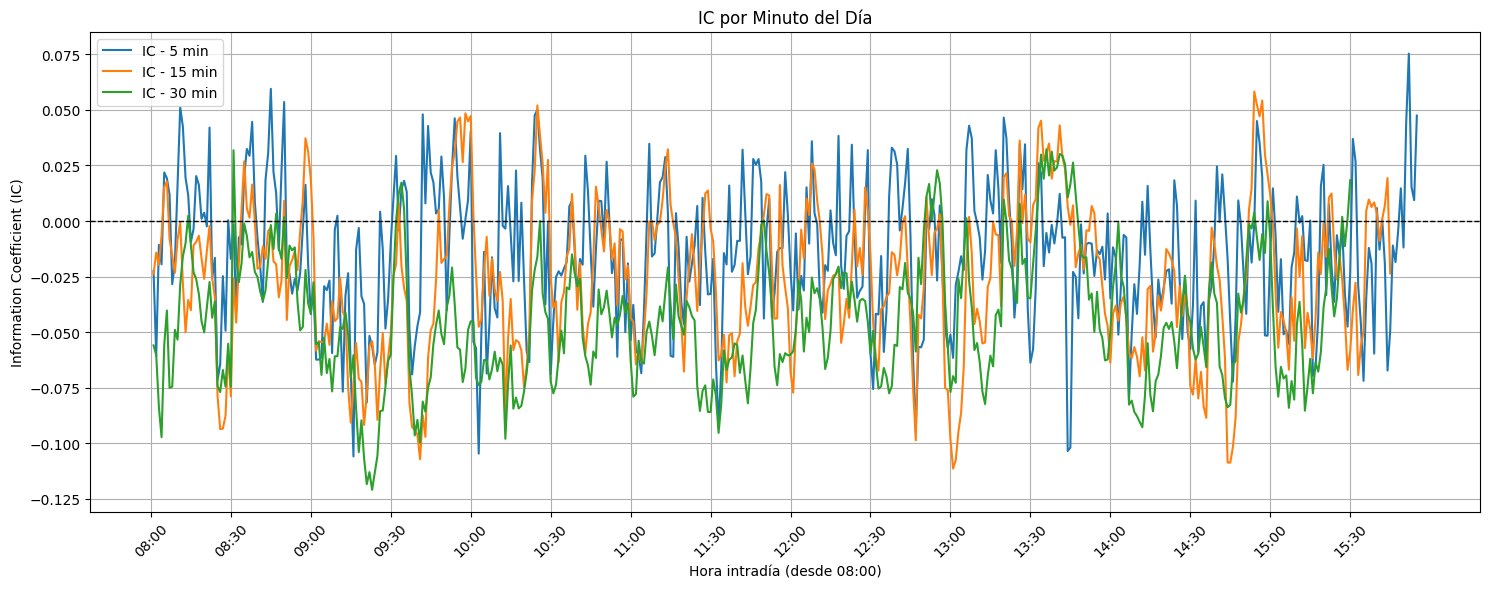

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
ic_rev_zscore_30,-0.120883,09:23,0.032287,13:36,-0.094196
ic_rev_zscore_15,-0.111339,13:01,0.058221,14:54,-0.092662
ic_rev_zscore_5,-0.105877,09:16,0.075271,15:52,-0.075124


In [17]:
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='reversal_score_5',
    factor_15='reversal_score_15',
    factor_30='reversal_score_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'ic_rev_zscore_5': ic_minute_5,
    'ic_rev_zscore_15': ic_minute_15,
    'ic_rev_zscore_30': ic_minute_30
})

# Ver los peores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)

1. Los ICs más negativos se concentran en la apertura y primeras horas del día

  - El mínimo IC de reversal_score_30 es -0.1209 a las 09:23, apenas pasada la apertura.
  - reversal_score_5 también alcanza su peor IC a las 09:16.
  
  Esto sugiere que la hipótesis de reversión puede fallar más en la apertura, donde hay más volatilidad e inestabilidad direccional.

2. Los mejores ICs (aunque bajos) aparecen en la tarde

  - reversal_score_30 alcanza su mejor valor positivo (0.0323) recién a las 13:36.
  - reversal_score_5 logra su pico positivo (0.0753) a las 15:52, cerca del cierre.
  
  Esto indica que la reversión a la media funciona mejor en las horas finales del día, posiblemente porque el mercado entra en rangos más definidos.

3. Los 30 peores ICs promedian un valor negativo fuerte
  
  Esto refuerza la validez de la hipótesis, ya que:
  - Aunque el promedio general del IC es bajo, el alpha factor muestra consistencia en producir señales opuestas al movimiento futuro (reversión) en los peores momentos del día.
  - El hecho de que el peor IC sea negativo en todos los casos, y que los promedios negativos sean más fuertes que los positivos, indica que la reversión tiene un efecto estadístico claro.

**Conclusión final:**

Aunque el reversal_score_N tiene un desempeño débil al inicio de la jornada, igual voy a incluirlo como alpha factor en mi modelo de machine learning. La reversión a la media intradía es un fenómeno real, y este factor captura esa lógica con suficiente consistencia, especialmente a partir del mediodía.

Además, confío en que el modelo podrá aprender cuándo confiar y cuándo no en esta señal, en función de la hora del día y otras condiciones del mercado. Como el modelo puede capturar relaciones no lineales y condicionales, incluso un factor débil en ciertos tramos del día puede aportar valor predictivo cuando se combina con otras variables.

Por eso, el reversal_score_30 será parte de las entradas de mi modelo IA para predicción intradía.

##6. Agregar el alpha factor a dataset

In [18]:
#Copiamos el dataset limpio
mnq_intraday = load_df()

In [23]:
def add_reversal_media_factor(df: pd.DataFrame, window: int = 30, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega al DataFrame un alpha factor basado en la hipótesis 2 (reversión a la media),
    llamado 'reversal_score_{window}', calculado como z-score normalizado por jornada.

    No guarda columnas intermedias.

    Parámetros:
    - df: DataFrame con columnas 'date' y una columna de precios (por defecto 'close')
    - window: Ventana para el cálculo del z-score (en minutos)
    - price_col: Nombre de la columna de precios

    Retorna:
    - El DataFrame original con una nueva columna 'reversal_score_{window}'
    """
    z_col = f'_tmp_z_{window}'
    reversal_col = f'reversal_media_factor'

    # Calcular z-score por jornada
    df[z_col] = df.groupby('date')[price_col].transform(
        lambda x: (x - x.rolling(window=window, min_periods=1).mean()) /
                  x.rolling(window=window, min_periods=1).std()
    )

    # Normalizar el z-score por jornada
    df[reversal_col] = df.groupby('date')[z_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # Eliminar columna temporal
    df.drop(columns=[z_col], inplace=True)

    return df



In [24]:
mnq_intraday = add_reversal_media_factor(mnq_intraday, window=30)


In [25]:
mnq_intraday

,open,high,low,close,volume,date,reversal_score_30,reversal_media_factor
datetime,,,,,,,,
2019-12-23 08:00:00-05:00,8734.00,8734.25,8733.75,8733.75,31,2019-12-23,NaN,NaN
2019-12-23 08:01:00-05:00,8734.00,8734.25,8733.75,8734.00,16,2019-12-23,0.640953,0.640953
2019-12-23 08:02:00-05:00,8734.00,8734.00,8733.25,8733.25,23,2019-12-23,-0.678763,-0.678763
2019-12-23 08:03:00-05:00,8734.25,8734.50,8734.00,8734.00,23,2019-12-23,0.640953,0.640953
2019-12-23 08:04:00-05:00,8734.00,8734.00,8733.50,8733.75,12,2019-12-23,0.121999,0.121999
...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,21624.50,21635.00,21613.50,21617.50,3251,2025-06-13,-0.771226,-0.771226
2025-06-13 15:57:00-04:00,21616.50,21635.25,21615.75,21623.75,2201,2025-06-13,-0.484803,-0.484803
2025-06-13 15:58:00-04:00,21623.25,21632.75,21616.50,21621.75,1859,2025-06-13,-0.559542,-0.559542
